# Stateful LSTM using PyTorch

[References]
- [PyTorch Discussion](https://discuss.pytorch.org/t/confusion-regarding-pytorch-lstms-compared-to-keras-stateful-lstm/44502)
- [PyTorch LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt

## Load Data

In [2]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(",")
lines = lines[1:]


temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 2))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, 0] = values[0]
    raw_data[i, 1:]= values[2:]

num_train_samples = int(0.6 * len(raw_data))
num_val_samples = int(0.2 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print('num_train_samples:', num_train_samples)
print('num_val_samples:', num_val_samples)
print('num_test_samples:', num_test_samples)

mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_train_samples].std(axis=0)

raw_data -= mean
raw_data /= std

X, y = raw_data, temperature

num_features = X.shape[1]
print('Number of features:', num_features)

num_train_samples: 252270
num_val_samples: 84090
num_test_samples: 84091
Number of features: 13


## What is stateful LSTM?

In [3]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_features = X.shape[1]
print('Number of features:', num_features)

cpu
Number of features: 13


## Data Loader for Stateful-LSTM

In [5]:
class SequenceDataset(Dataset):
    def __init__(self, X_array, y_array, sampling_rate, sequence_stride, sequence_length, delay):
        super(Dataset, self).__init__()

        self.sr = sampling_rate
        self.seq_stride = sequence_stride
        self.seq_len = sequence_length
        self.delay = delay
        self.X = torch.tensor(X_array).to(torch.float32)
        self.y = torch.tensor(y_array).to(torch.float32)

    def __len__(self):
        return (self.X.size(0) - self.delay)//self.seq_stride

    def __getitem__(self, i): 
        idx = np.arange(i*self.seq_stride, i*self.seq_stride + self.sr*self.seq_len, self.sr)
        return self.X[idx], self.y[i*self.seq_stride + self.delay]

In [6]:
int_sequence = np.arange(130)
dummy_dataset = SequenceDataset(int_sequence, int_sequence,
                                sampling_rate=2, sequence_stride=4, sequence_length=6, 
                                delay=20)
dummy_loader = DataLoader(dummy_dataset, batch_size=3, shuffle=False)

In [7]:
len(dummy_dataset)

27

In [8]:
for inputs, targets in dummy_loader:
    
    '''
    inputs shape : (batch_size, sequence_length)
    targets shape : (batch_size, )
    '''

    print("==========================")
    
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 2, 4, 6, 8, 10] 20
[4, 6, 8, 10, 12, 14] 24
[8, 10, 12, 14, 16, 18] 28
[12, 14, 16, 18, 20, 22] 32
[16, 18, 20, 22, 24, 26] 36
[20, 22, 24, 26, 28, 30] 40
[24, 26, 28, 30, 32, 34] 44
[28, 30, 32, 34, 36, 38] 48
[32, 34, 36, 38, 40, 42] 52
[36, 38, 40, 42, 44, 46] 56
[40, 42, 44, 46, 48, 50] 60
[44, 46, 48, 50, 52, 54] 64
[48, 50, 52, 54, 56, 58] 68
[52, 54, 56, 58, 60, 62] 72
[56, 58, 60, 62, 64, 66] 76
[60, 62, 64, 66, 68, 70] 80
[64, 66, 68, 70, 72, 74] 84
[68, 70, 72, 74, 76, 78] 88
[72, 74, 76, 78, 80, 82] 92
[76, 78, 80, 82, 84, 86] 96
[80, 82, 84, 86, 88, 90] 100
[84, 86, 88, 90, 92, 94] 104
[88, 90, 92, 94, 96, 98] 108
[92, 94, 96, 98, 100, 102] 112
[96, 98, 100, 102, 104, 106] 116
[100, 102, 104, 106, 108, 110] 120
[104, 106, 108, 110, 112, 114] 124


**To use `stateful=True` mode in LSTM (RNN), you should follow the rules below:**

- Do **NOT** shuffle the dataset
- `sequence_stride` $\times$ `batch_size` = `sequence_length` $\times$ `sampling_rate`
- Each batch need to have the same number of samples, i.e., the number of samples needs to divisible by `batch_size`.

In [9]:
# Observations will be sampled at one data point per hour
sampling_rate=6

# Observations will go back 5 days (120 hours)
sequence_length = 120

# The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length - 1) + sampling_rate*24 
print('Delay: ', delay)


sequence_stride=1
batch_size = sampling_rate*sequence_length
print('Batch Size: ', batch_size)

Delay:  858
Batch Size:  720


In [10]:
# Adjusting the number of train/validation/test samples

print('Reduce the number of train samples: ', (num_train_samples-delay)%720)
print('Reduce the number of valid samples: ', (num_val_samples-delay)%720)
print('Reduce the number of test  samples: ', (num_test_samples-delay)%720)

Reduce the number of train samples:  132
Reduce the number of valid samples:  432
Reduce the number of test  samples:  433


In [11]:
train_dataset = SequenceDataset(X[:num_train_samples-132], 
                                y[:num_train_samples-132], 
                                sampling_rate=sampling_rate, 
                                sequence_stride=1,
                                sequence_length=sequence_length,
                                delay = delay)

valid_dataset = SequenceDataset(X[num_train_samples:num_train_samples+num_val_samples-432], 
                                y[num_train_samples:num_train_samples+num_val_samples-432], 
                                sampling_rate=sampling_rate, 
                                sequence_stride=1,
                                sequence_length=sequence_length,
                                delay = delay)

test_dataset = SequenceDataset(X[num_train_samples+num_val_samples:num_train_samples+num_val_samples+num_test_samples-433],
                               y[num_train_samples+num_val_samples:num_train_samples+num_val_samples+num_test_samples-433], 
                               sampling_rate=sampling_rate, 
                               sequence_stride=1,
                               sequence_length=sequence_length,
                               delay = delay)


In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
for samples, targets in test_loader:
    print('samples shape:', samples.shape)
    print('targets shape:', targets.shape)
    break

samples shape: torch.Size([720, 120, 13])
targets shape: torch.Size([720])


## Stateful LSTM model

- Using PyTorch, we store the hidden/cell state vectors from the previous batch. Then we use the vectors as the initial hidden/cell state vectors in the next batch.
- `train` and `test` functions should be changed from those for the original LSTM models.

In [14]:
class stateful_LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(stateful_LSTM_model, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size  = input_size,
            hidden_size = hidden_size,
            num_layers  = 1,              # The number of stacked RNN layers
            batch_first = True            # Default: False
        )

        self.linear = nn.Linear(
            in_features = hidden_size, 
            out_features=1, 
            bias=True
        )

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        
        '''
        output size : (batch_size, sequence_length, num_layers * hidden_size)
        -> hidden state vectors (NOT CELL STATE VECTORS) for each time step, for each layer.

        h_n : (num_layers, batch_size, hidden_size) 
        c_n : (num_layers, batch_size, hidden_size)
        '''
        
        x = h_n.squeeze(0)
        
        '''
        Reshape to (batch_size, hidden_size) : an appropriate shape for a linear layer input
        '''
        
        x = self.linear(x)

        return x, h_n, c_n

In [15]:
hidden_size=16
model = stateful_LSTM_model(input_size=num_features, hidden_size=hidden_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 15

In [16]:
def train(model, trainloader, validloader, criterion, optimizer, epoch, device):
    
    losses = []
    val_losses = []
    model.to(device)
    model.train()

    for i in range(1, epoch+1):
        count = 0
        train_loss = 0
        
        for X, y in tqdm(trainloader):
            X = X.to(device)
            y = y.to(device)

            output, h_n, c_n = model(X)
            loss = criterion(output.squeeze(1), y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            count += 1

        train_loss /= count
        losses.append(train_loss)

        count = 0
        valid_loss = 0
        with torch.no_grad():
            for X, y in validloader:
                X = X.to(device)
                y = y.to(device)

                output, h_n, c_n = model(X)
                loss = criterion(output.view(-1), y)
                valid_loss += loss.item()
                count += 1
            
        valid_loss /= count
        val_losses.append(valid_loss)

        print('EPOCH %d Completed. \n Training Loss: %.3f, Validation Loss: %.3f \n' 
              %(i, train_loss, valid_loss))

    return losses, val_losses

In [17]:
def test(model, evalloader, criterion, device):
    eval_loss = 0
    count = 0
    model.eval()
    predictions = np.empty([0])

    with torch.no_grad():
        for X, y in evalloader:
            X = X.to(device)
            y = y.to(device)

            output, h_n, c_n = model(X)
            predictions = np.append(predictions, output.view(-1).numpy())

            loss = criterion(output.view(-1), y)
            eval_loss += loss.item()
            count += 1
        
    eval_loss /= count
    
    return predictions, eval_loss

In [18]:
train_loss, val_loss = train(model, train_loader, valid_loader, criterion, optimizer, EPOCHS, device)

100%|██████████| 349/349 [01:03<00:00,  5.51it/s]


EPOCH 1 Completed. 
 Training Loss: 108.381, Validation Loss: 47.076 



100%|██████████| 349/349 [01:02<00:00,  5.56it/s]


EPOCH 2 Completed. 
 Training Loss: 48.888, Validation Loss: 27.626 



100%|██████████| 349/349 [01:00<00:00,  5.75it/s]


EPOCH 3 Completed. 
 Training Loss: 31.256, Validation Loss: 19.363 



100%|██████████| 349/349 [00:54<00:00,  6.42it/s]


EPOCH 4 Completed. 
 Training Loss: 22.582, Validation Loss: 15.404 



100%|██████████| 349/349 [00:54<00:00,  6.42it/s]


EPOCH 5 Completed. 
 Training Loss: 17.983, Validation Loss: 13.329 



100%|██████████| 349/349 [00:54<00:00,  6.45it/s]


EPOCH 6 Completed. 
 Training Loss: 15.312, Validation Loss: 12.233 



100%|██████████| 349/349 [00:53<00:00,  6.53it/s]


EPOCH 7 Completed. 
 Training Loss: 13.708, Validation Loss: 11.545 



100%|██████████| 349/349 [00:53<00:00,  6.47it/s]


EPOCH 8 Completed. 
 Training Loss: 12.764, Validation Loss: 11.095 



100%|██████████| 349/349 [00:54<00:00,  6.43it/s]


EPOCH 9 Completed. 
 Training Loss: 12.112, Validation Loss: 10.778 



100%|██████████| 349/349 [00:53<00:00,  6.49it/s]


EPOCH 10 Completed. 
 Training Loss: 11.680, Validation Loss: 10.548 



100%|██████████| 349/349 [00:53<00:00,  6.47it/s]


EPOCH 11 Completed. 
 Training Loss: 11.374, Validation Loss: 10.360 



100%|██████████| 349/349 [00:53<00:00,  6.47it/s]


EPOCH 12 Completed. 
 Training Loss: 11.119, Validation Loss: 10.257 



100%|██████████| 349/349 [00:53<00:00,  6.57it/s]


EPOCH 13 Completed. 
 Training Loss: 10.960, Validation Loss: 10.153 



100%|██████████| 349/349 [00:52<00:00,  6.62it/s]


EPOCH 14 Completed. 
 Training Loss: 10.823, Validation Loss: 10.097 



100%|██████████| 349/349 [00:52<00:00,  6.59it/s]


EPOCH 15 Completed. 
 Training Loss: 10.721, Validation Loss: 10.053 



In [19]:
predictions, eval_loss = test(model, test_loader, criterion, device)

In [20]:
test_targets = np.empty([0])

for X, y in test_loader:
    test_targets = np.append(test_targets, y.numpy())

test_num = test_targets.shape[0]
print(test_num)

82800


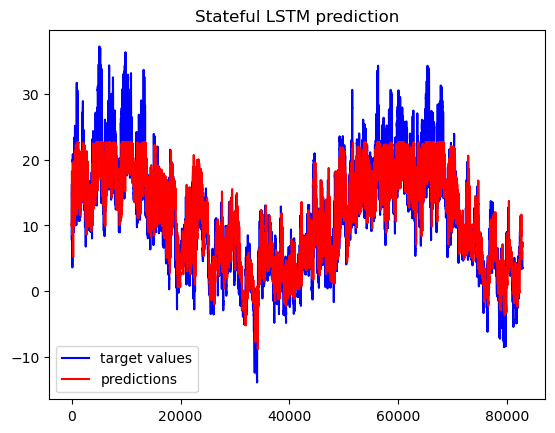

In [21]:
x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions, label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()

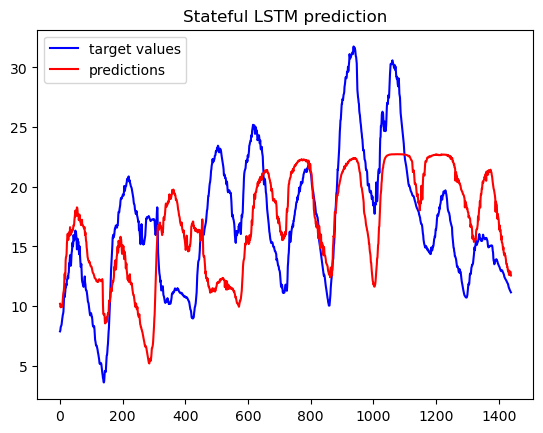

In [22]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions[:1440], label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()

## Future Works

Compare between stateful LSTM with `shorter sequence length` and that with `longer sequence length`.